This based off of the tutorial from scanpy using pbmc 3K.
https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

And heavily influenced by https://github.com/theislab/scanpy_usage/blob/master/170503_zheng17/zheng17.ipynb

# Imports

In [15]:
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
from sc_preprocessing import sc_preprocess

# general imports
import warnings
import numpy as np
import os
import pandas as pd
import scipy as sp
from scipy.sparse import coo_matrix
import collections
import scanpy as sc


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
import sklearn as sk

# matplotlib settings for Jupyter notebooks only
%matplotlib inline

import pickle
import gzip
from pathlib import Path


# Parameters

In [16]:
# parameters
GSE_data_path = f"{os.getcwd()}/../data/single_cell_data/GSE132044/"
aug_data_path = f"{os.getcwd()}/../data/single_cell_data/augmented_pbmc_data/"
cybersort_path = f"{os.getcwd()}/../data/single_cell_data/cybersort_pbmc/"
scpred_path = f"{os.getcwd()}/../results/single_cell_data/pbmc_cell_labels/"

# sm2 path
data_path = f"{os.getcwd()}/../data/single_cell_data/GSE132044/sm2_hg19/"

smart_seq2_param = pd.DataFrame({"Method":'Smart-seq2', 
                    "Experiment":'pbmc1', 
                    "file_id":'pbmc_rep1_sm2'}, index=[0])

pbmc1_10x_param = pd.DataFrame({"Method":'10x Chromium (v2) A', 
                    "Experiment":'pbmc1', 
                    "file_id":'pbmc_rep1_10xV2a'}, index=[0])


pbmc2_10x_param = pd.DataFrame({"Method":'10x Chromium (v2)', 
                    "Experiment":'pbmc2', 
                    "file_id":'pbmc_rep2_10xV2'}, index=[0])

num_cells_vec = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]


#####################
### set the study ###
#####################
curr_study = smart_seq2_param

res_name = curr_study["file_id"][0]
exp_str = curr_study["Experiment"][0]
method_str = curr_study["Method"][0]

results_file = f"{data_path}/{res_name}.h5ad"



# Load and Process data

### Read in data and metadata

In [17]:
# read in the data

adata = sc.read_10x_mtx(
    data_path,                               # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`



In [18]:
# add metadata

# add metadata
meta_data = pd.read_csv(f"{scpred_path}/{res_name}.tsv", sep="\t", index_col='code')
barcodes = pd.read_csv(f"{data_path}/barcodes.tsv", header=None, names=['code'])
meta_df = barcodes.join(other=meta_data, on=['code'], how='left', sort=False)


adata.obs['CellType'] = meta_df['CellType'].tolist()
adata.obs['scpred_CellType'] = meta_df['scpred_prediction'].tolist()
adata.obs['Experiment'] = meta_df['Experiment'].tolist()
adata.obs['Method'] = meta_df['Method'].tolist()


In [19]:
from collections import Counter

Counter(meta_df['scpred_prediction'].tolist())

Counter({nan: 44764,
         'nk': 30,
         'cd8': 84,
         'unassigned': 17,
         'cd4': 22,
         'cd4_cd8_naive': 20,
         'hsc': 1,
         'unclassified': 1,
         'mono14': 30,
         'adc': 3,
         'mono16': 9,
         'pdc': 2,
         'b': 22,
         'mk': 12})

### Preprocess

In [20]:
# filter it for only our method and experiment
adata = adata[adata.obs["Experiment"] == exp_str, :]
adata = adata[adata.obs["Method"] == method_str, :]


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


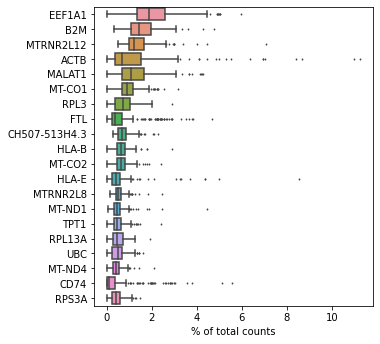

In [21]:
sc.pl.highest_expr_genes(adata, n_top=20, )


In [22]:
# filter out cells with less than 200 genes and genes expressed in less than 3 cells
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'CellType' as categorical
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'scpred_CellType' as categorical
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Cat

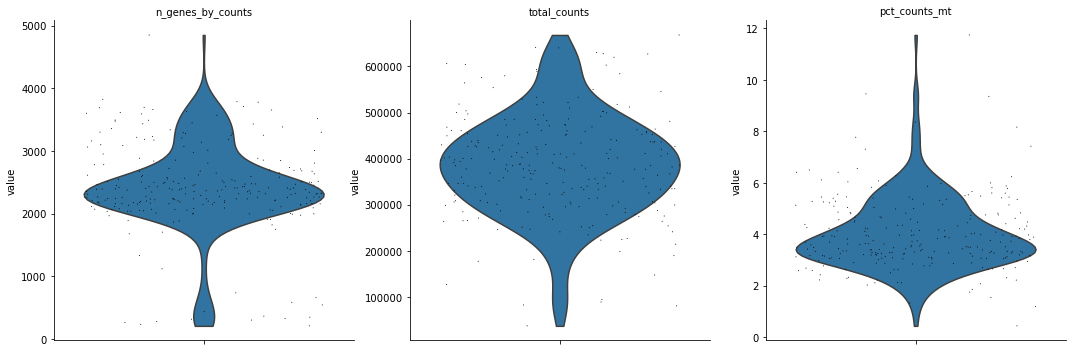

In [23]:
# remove genes with high mitochondrial content
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

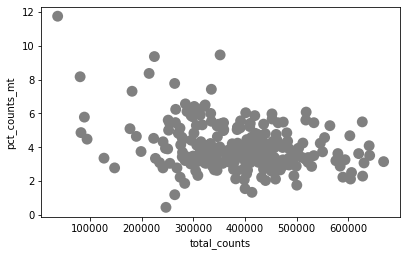

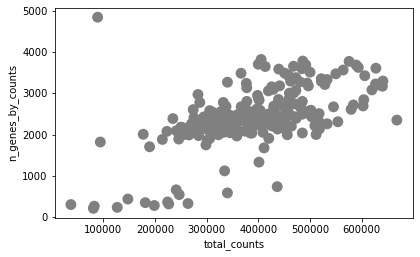

In [24]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [25]:
# slice the data based on the plots from above
# remove cells with more than 3500 genes
# remove cells with more than 10% MTgenes
adata = adata[adata.obs.n_genes_by_counts < 4000, :]
adata = adata[adata.obs.pct_counts_mt < 10, :]


# normalize to 10K counts per cell
sc.pp.normalize_total(adata, target_sum=1e4)


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [26]:
# remove cells that are unlabeled or unclassified
cell_type_id = adata.obs["scpred_CellType"].values.unique()
cell_type_remove = ["unassigned", "unclassified"]
cell_type_id = set(cell_type_id).difference(set(cell_type_remove))
adata = adata[adata.obs["scpred_CellType"].isin(cell_type_id)]
adata.obs["scpred_CellType"].values.unique()

['nk', 'cd8', 'cd4', 'cd4_cd8_naive', 'mono14', 'adc', 'mono16', 'pdc', 'b', 'mk']
Categories (10, object): ['adc', 'b', 'cd4', 'cd4_cd8_naive', ..., 'mono14', 'mono16', 'nk', 'pdc']

In [27]:
# group together cell types that are not very frequent

all_vals = adata.obs["scpred_CellType"].to_list()
all_vals = np.char.replace(all_vals, 'adc', 'other')
all_vals = np.char.replace(all_vals, 'pdc', 'other')
all_vals = np.char.replace(all_vals, 'mk', 'other')
all_vals = np.char.replace(all_vals, 'hsc', 'other')
adata.obs["scpred_CellType"] = all_vals

from collections import Counter

Counter(all_vals)


Trying to set attribute `.obs` of view, copying.


Counter({'nk': 30,
         'cd8': 84,
         'cd4': 22,
         'cd4_cd8_naive': 20,
         'mono14': 30,
         'other': 17,
         'mono16': 9,
         'b': 22})

In [28]:
# write out data for BP and cibersort
dense_matrix = adata.X.todense()

sc_profile_file = os.path.join(aug_data_path, f"{res_name}_sig.pkl")
sc_profile_path = Path(sc_profile_file)
pickle.dump( dense_matrix, open( sc_profile_path, "wb" ) )


# Plot Data

         Falling back to preprocessing with `sc.pp.pca` and default params.


OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'scpred_CellType' as categorical


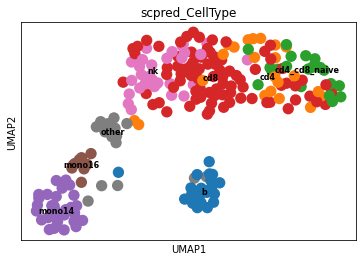

In [29]:
# valculate neighborhood graph
sc.pp.neighbors(adata)

# make umap
sc.tl.umap(adata)

# plot some markers of the RAW data
sc.pl.umap(adata, legend_loc='on data', color='scpred_CellType', legend_fontsize=8)


# Make Pseudobulks

In [30]:
# write out the gene ids
gene_pass = adata.var['gene_ids']
gene_out_file = os.path.join(aug_data_path, f"{res_name}_genes.pkl")
gene_out_path = Path(gene_out_file)
pickle.dump( gene_pass, open( gene_out_path, "wb" ) )


# simulate different number of cells
num_samples = 1000
for idx in range(len(num_cells_vec)):
  print(f"New Domain {idx}")
  pbmc_rep1_pseudobulk_file = os.path.join(aug_data_path, f"{res_name}_pseudo_{idx}.pkl")
  pbmc_rep1_prop_file = os.path.join(aug_data_path, f"{res_name}_prop_{idx}.pkl")

  pseudobulk_path = Path(pbmc_rep1_pseudobulk_file)
  prop_path = Path(pbmc_rep1_prop_file)

  if not pseudobulk_path.is_file(): # skip if we already generated it

    # make the pseudobulks
    num_cells = num_cells_vec[idx]
    prop_df, pseudobulks_df = sc_preprocess.make_prop_and_sum(adata, 
                                                num_samples, 
                                                num_cells,
                                                use_true_prop=False)

    # make the proportions instead of cell counts
    prop_df = prop_df.div(prop_df.sum(axis=1), axis=0)

    pickle.dump( prop_df, open( prop_path, "wb" ) )
    pickle.dump( pseudobulks_df, open( pseudobulk_path, "wb" ) )


    if not np.all(np.isclose(prop_df.sum(axis=1), 1.)):
        assert False, "Proportions do not sum to 1"



New Domain 0
0
100
200
300
400
500
600
700
800
900
New Domain 1
0
100
200
300
400
500
600
700
800
900
New Domain 2
0
100
200
300
400
500
600
700
800
900
New Domain 3
0
100
200
300
400
500
600
700
800
900
New Domain 4
0
100
200
300
400
500
600
700
800
900
New Domain 5
0
100
200
300
400
500
600
700
800
900
New Domain 6
0
100
200
300
400
500
600
700
800
900
New Domain 7
0
100
200
300
400
500
600
700
800
900
New Domain 8
0
100
200
300
400
500
600
700
800
900
New Domain 9
0
100
200
300
400
500
600
700
800
900
